# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal /workspace/data/MovieLens/data .

In [5]:
!hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2021-02-10 15:18 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-10 15:18 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-10 15:18 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-10 15:18 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-10 15:18 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2021-02-10 15:18 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-10 15:19 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-10 15:19 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-10 15:19 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 4.03 ms, sys: 1.16 ms, total: 5.19 ms
Wall time: 1.17 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 24.9 ms, sys: 4.08 ms, total: 29 ms
Wall time: 35.5 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 58.1 s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 9.4 ms, sys: 0 ns, total: 9.4 ms
Wall time: 16.9 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196631, (5.0, ['196631', 'Red Is the Color of (2007)'])),
 (131188, (5.0, ['131188', 'A Man To Remember (1938)'])),
 (207642, (5.0, ['207642', 'Kabir Singh (2019)'])),
 (193964, (5.0, ['193964', 'The Jade Pendant (2017)'])),
 (148254, (5.0, ['148254', 'A Dark Place Inside'])),
 (181175, (5.0, ['181175', 'War Requiem (1989)'])),
 (83161, (5.0, ['83161', 'Deadly Delicious (Shuang Shi Ji) (2008)'])),
 (165775, (5.0, ['165775', 'Four Mothers (1941)'])),
 (182589, (5.0, ['182589', 'Witchcraft 15: Blood Rose (2017)'])),
 (149850, (5.0, ['149850', '"Another Time']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-10 15:21 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      59139 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112222 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131258 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114186 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133841 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117681 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143063 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132134 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167794 2021-02-10 15:21 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

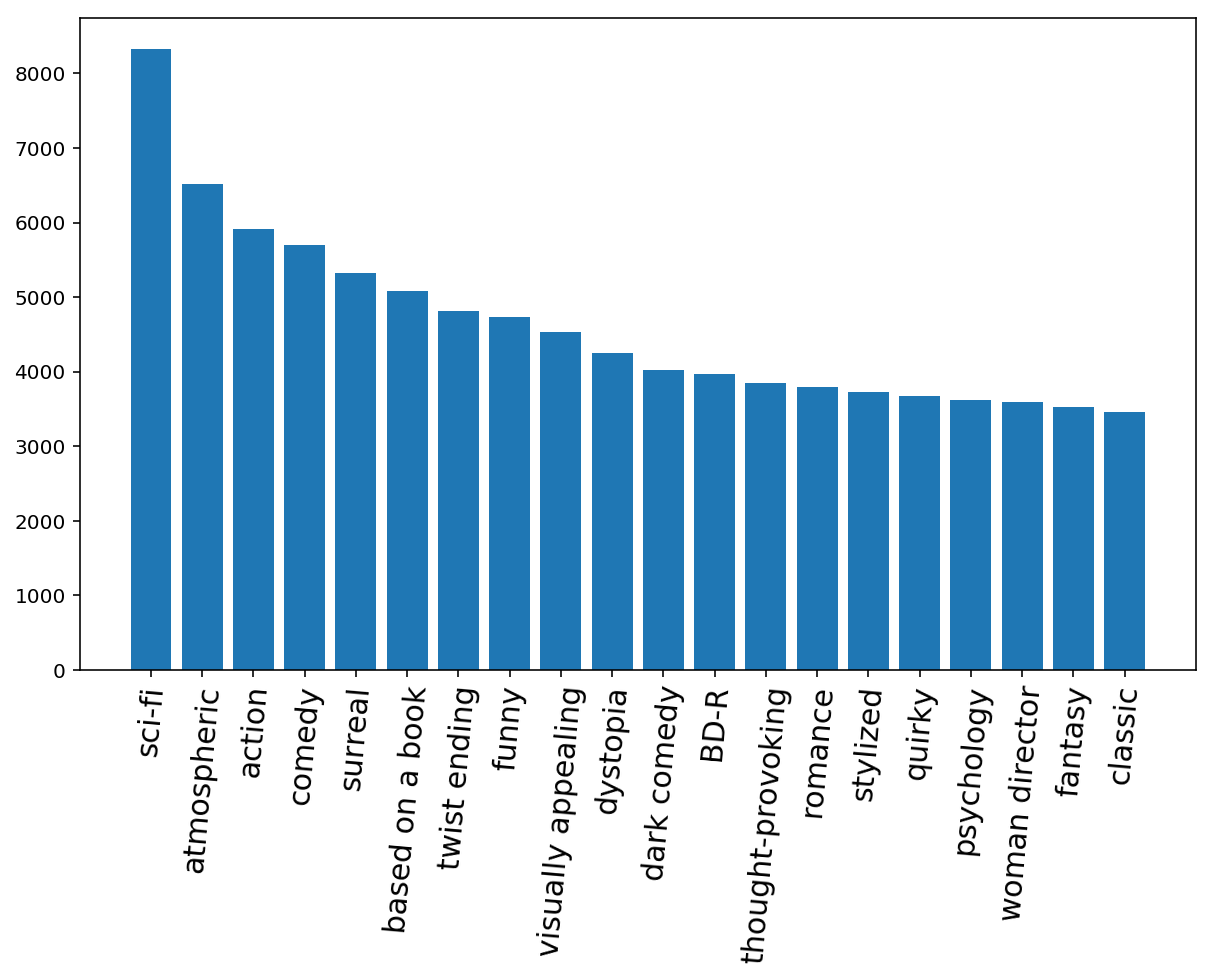

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
voice_movie = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

voice_movie \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda m: (m[1][0], m[1][1][1]))\
    .take(10)

[(81491, 'Forrest Gump (1994)'),
 (81482, '"Shawshank Redemption'),
 (79672, 'Pulp Fiction (1994)'),
 (74127, '"Silence of the Lambs'),
 (72674, '"Matrix'),
 (68717, 'Star Wars: Episode IV - A New Hope (1977)'),
 (64144, 'Jurassic Park (1993)'),
 (60411, "Schindler's List (1993)"),
 (59184, 'Braveheart (1995)'),
 (58773, 'Fight Club (1999)')]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
movie_five = ratings \
    .map(lambda r: (r.movie_id, int(r.rating == 5))) \
    .reduceByKey(lambda a, b: a + b)

movie_five = ratings \
    .filter(lambda r: r.rating == 5)\
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

movie_five \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .map(lambda m: (m[1][0], m[1][1][1]))\
    .take(10)

[(39553, '"Shawshank Redemption'),
 (32169, 'Pulp Fiction (1994)'),
 (25918, 'Forrest Gump (1994)'),
 (25804, 'Star Wars: Episode IV - A New Hope (1977)'),
 (25482, '"Matrix'),
 (24853, "Schindler's List (1993)"),
 (24801, '"Silence of the Lambs'),
 (24418, '"Godfather'),
 (21585, '"Usual Suspects'),
 (21486, 'Fight Club (1999)')]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

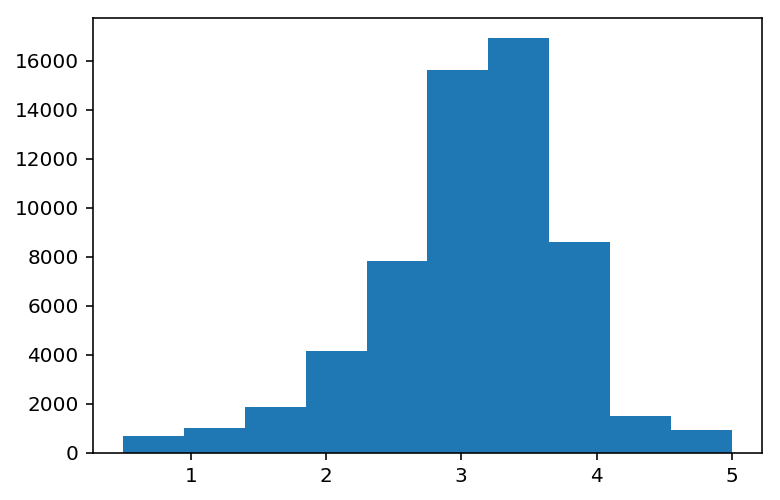

In [26]:
avg_rating = movie_avg_rating.map(lambda m: m[1]).collect()
plt.hist(avg_rating);

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

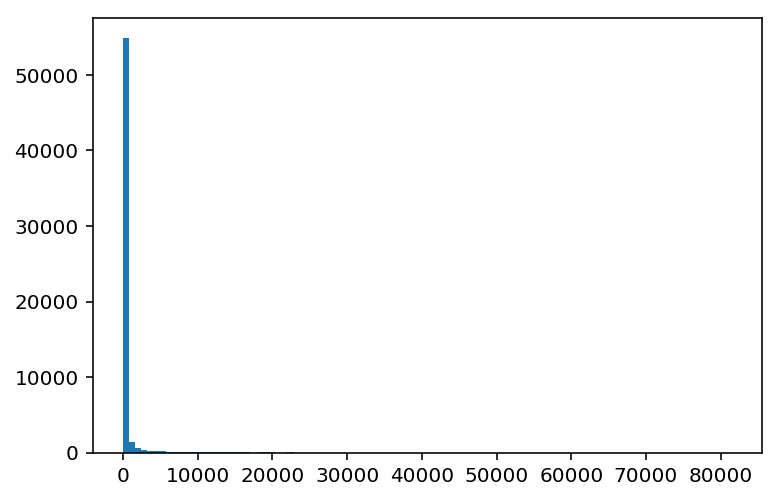

In [27]:
voices = voice_movie.map(lambda m: m[1]).collect()
plt.hist(voices, bins=100);

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [77]:
genres = sc.textFile(MOVIES_PATH)
genres = genres \
    .flatMap(lambda s: [(g, 1) for g in s.split(',')[-1].split('|')])\
    .filter(lambda arr: arr[0] != 'genres')\
    .reduceByKey(lambda a, b: a + b)

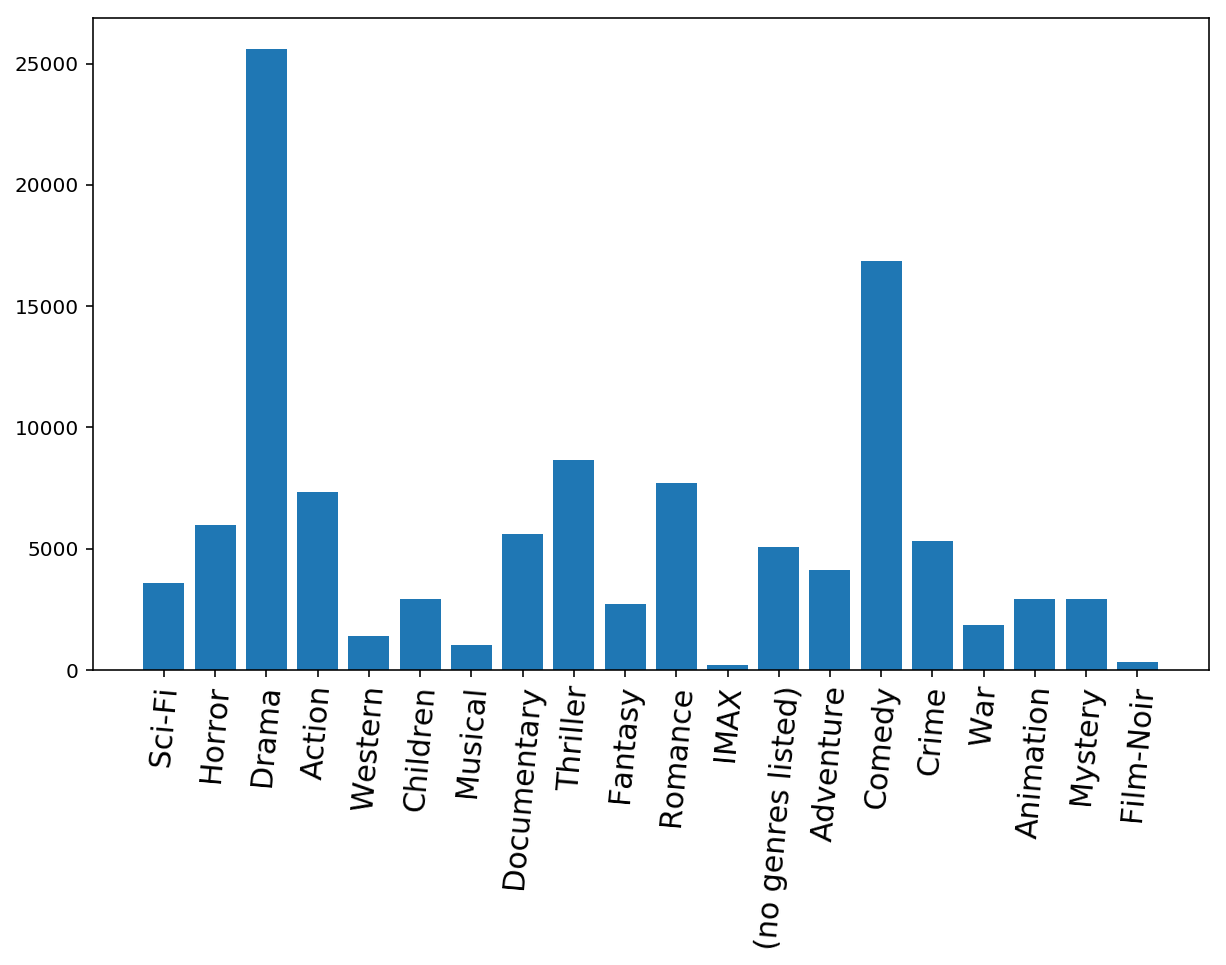

In [80]:
keys, values = zip(*genres.collect())

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [24]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, "ratings.csv")
MOVIES_PATH = os.path.join(DATA_PATH, "movies.csv")
LINKS_PATH = os.path.join(DATA_PATH, "links.csv")
TMDB_PATH = os.path.join(DATA_PATH, "tmdb.json")

ratings = sc.textFile(RATINGS_PATH)
movies = sc.textFile(MOVIES_PATH)
links = sc.textFile(LINKS_PATH)
tmdb = sqlContext.read.json(TMDB_PATH).rdd

In [25]:
movies_ = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: arr[0])
movies_.take(10)

[('1', ['1', 'Toy Story (1995)']),
 ('2', ['2', 'Jumanji (1995)']),
 ('3', ['3', 'Grumpier Old Men (1995)']),
 ('4', ['4', 'Waiting to Exhale (1995)']),
 ('5', ['5', 'Father of the Bride Part II (1995)']),
 ('6', ['6', 'Heat (1995)']),
 ('7', ['7', 'Sabrina (1995)']),
 ('8', ['8', 'Tom and Huck (1995)']),
 ('9', ['9', 'Sudden Death (1995)']),
 ('10', ['10', 'GoldenEye (1995)'])]

In [26]:
tmdb_movie_id = tmdb\
    .filter(lambda row: hasattr(row.casts, "cast") and 31 in [cast.id for cast in row.casts.cast])\
    .map(lambda row: row.id)\
    .keyBy(lambda id: str(id))

In [27]:
tmdb_movie_id.take(5)

[('862', 862), ('568', 568), ('13', 13), ('9800', 9800), ('858', 858)]

In [28]:
links.take(1)

['movieId,imdbId,tmdbId']

In [29]:
links_id = links\
    .map(lambda s: s.split(','))\
    .filter(lambda row: row[0].isdigit())\
    .map(lambda row: (row[0], row[2]))\
    .keyBy(lambda row: row[1])

In [30]:
links_id.take(5)

[('862', ('1', '862')),
 ('8844', ('2', '8844')),
 ('15602', ('3', '15602')),
 ('31357', ('4', '31357')),
 ('11862', ('5', '11862'))]

In [31]:
tmdb_movie_id\
    .join(links_id)\
    .map(lambda row: row[1][1])\
    .keyBy(lambda row: row[0])\
    .join(movies_)\
    .map(lambda row: row[1][1][1])\
    .collect()

['Cast Away (2000)',
 '"Man with One Red Shoe',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 'Extremely Loud and Incredibly Close (2011)',
 'Ithaca (2015)',
 'Toy Story of Terror (2013)',
 '"Terminal',
 "Defying the Nazis: The Sharps' War (2016)",
 'Volunteers (1985)',
 'Catch Me If You Can (2002)',
 'Toy Story (1995)',
 '"\'burbs',
 'Road to Perdition (2002)',
 'Saving Private Ryan (1998)',
 'Toy Story Toons: Small Fry (2011)',
 '"Green Mile',
 'Angels & Demons (2009)',
 'Cars (2006)',
 'Nothing in Common (1986)',
 'Splash (1984)',
 'Shooting War (2000)',
 'Everything Is Copy (2015)',
 'The Circle (2016)',
 'Mazes and Monsters (1982)',
 '"The Mayo Clinic',
 '"Celluloid Closet',
 'Apollo 13 (1995)',
 'Inferno (2016)',
 'Radio Flyer (1992)',
 'Sully (2016)',
 'And the Oscar Goes To... (2014)',
 'Joe Versus the Volcano (1990)',
 'Killing Lincoln (2013)',
 '"Pixar Story',
 'Elvis Has Left the Building (2004)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Bachelor P

In [32]:
cast_id = tmdb\
    .filter(lambda row: hasattr(row.casts, "cast"))\
    .flatMap(lambda row: [(cast.name, 1) for cast in row.casts.cast])\
    .reduceByKey(lambda a, b: a + b)\
    .sortBy(lambda name : name[1], ascending=False)

In [33]:
cast_id.take(10)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [53]:
import numpy as np

In [52]:
unique_genres = np.array(
    tmdb\
    .filter(lambda row: row.genres and row.release_date)\
    .flatMap(lambda row : [g.name for g in row.genres])\
    .distinct()\
    .collect()
)

In [144]:
table = np.array(tmdb\
    .filter(lambda row: row.genres and row.release_date)\
    .map(lambda row : (int(row.release_date[:4]), np.sum(np.array([g.name for g in row.genres]).reshape(-1, 1) == unique_genres, axis = 0)))\
    .reduceByKey(lambda a, b : a + b)\
    .mapValues(lambda row : row / np.sum(row))\
    .sortBy(lambda row: row[0])\
    .collect())

In [145]:
x = table[:, 0].astype('int')
y = np.vstack(table[:, 1]).T

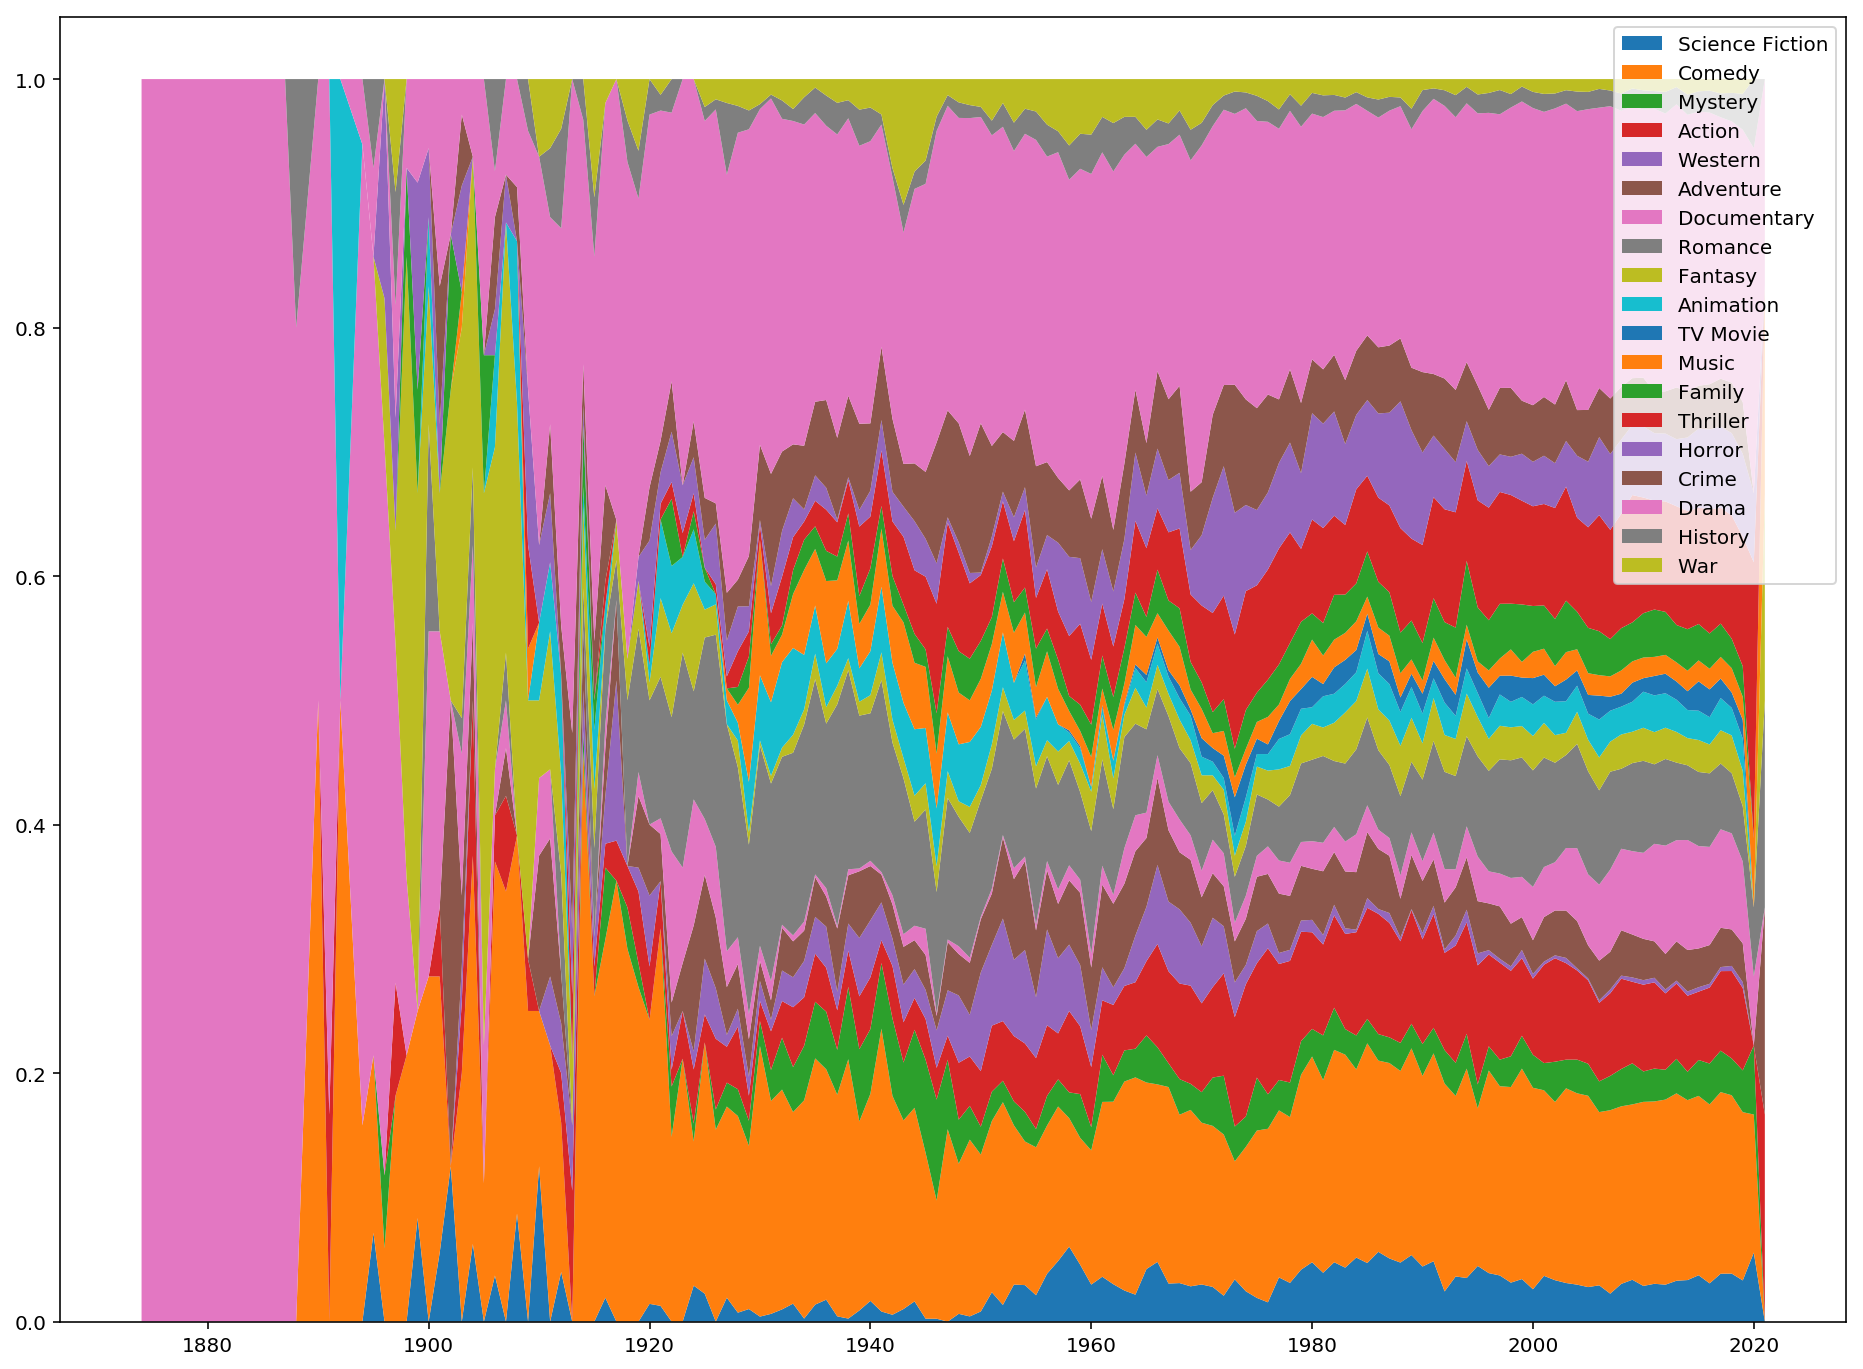

In [147]:
plt.figure(figsize = (16, 12))
plt.stackplot(x, *y, labels = unique_genres)
plt.legend()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [149]:
roi = np.array(
    tmdb\
    .filter(lambda row: row.genres)\
    .flatMap(lambda row : [(g.name, (row.revenue, row.budget)) for g in row.genres])\
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda row: row[0]/row[1])\
    .sortBy(lambda row: row[1])\
    .collect()
)

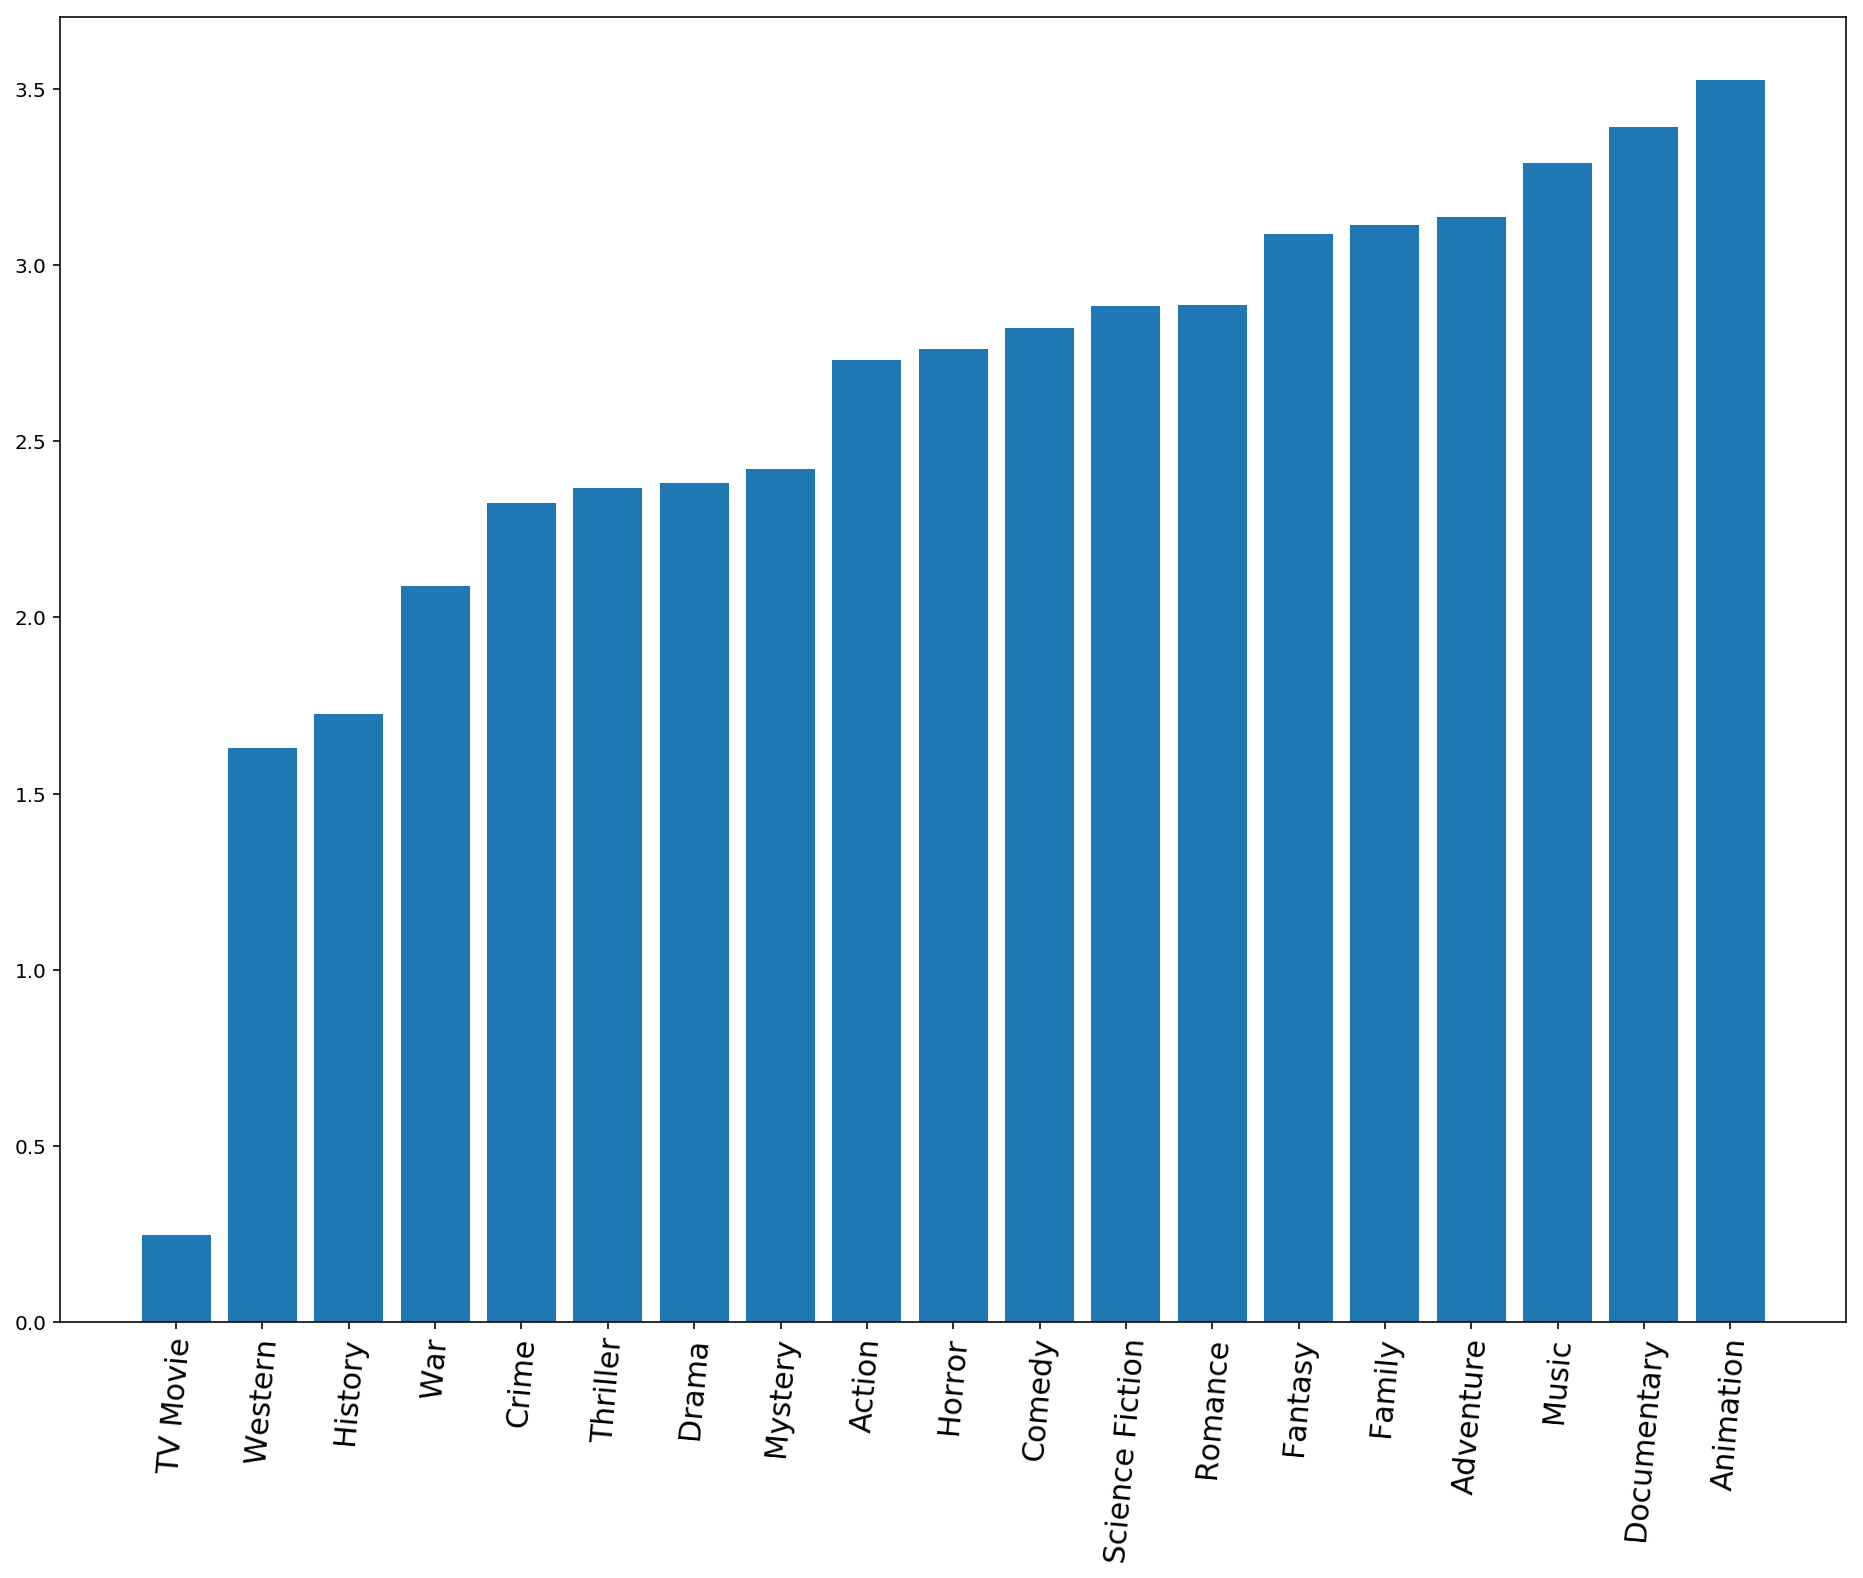

In [160]:
keys, values = roi[:, 0], roi[:, 1].astype(np.float)

plt.figure(figsize=(16, 12))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()